In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 10)           2570        ['dense_1[0][0]']                
                                                                                            

2024-04-24 14:20:11.956921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270,096
Trainable params: 270,096
Non-trainable params: 0
_________________________________________________________________


## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 10s 17ms/step - loss: 222.8367
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 138.8437
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 125.9653
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 120.1174
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 116.8425
Epoch 6/10
469/469 [==============================] - 6s 14ms/step - loss: 113.7814
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 112.0824
Epoch 8/10
469/469 [==============================] - 8s 16ms/step - loss: 110.6871
Epoch 9/10
469/469 [==============================] - 6s 14ms/step - loss: 109.5420
Epoch 10/10
469/469 [==============================] - 7s 15ms/step - loss: 108.5088


## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)

In [13]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

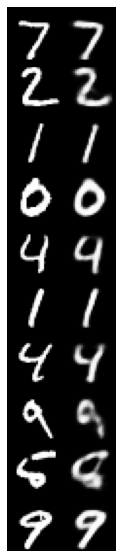

In [15]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

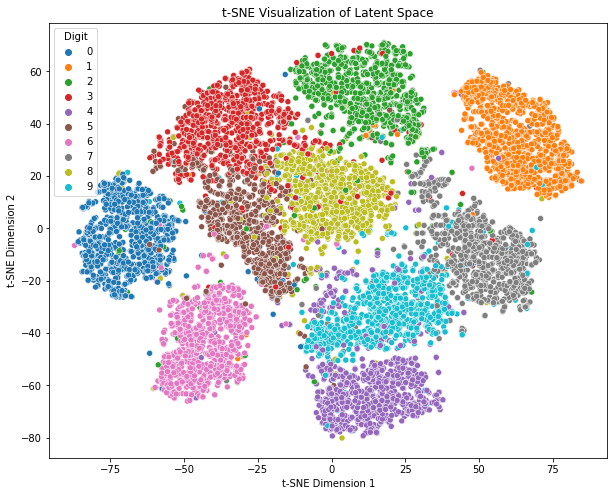

In [16]:
from sklearn.manifold import TSNE

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

# Plotting
N = 10000  # Number of points to plot, adjust as needed
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z_test_pred_tsne[:N, 0], y=z_test_pred_tsne[:N, 1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Digit')
plt.show()


## h)

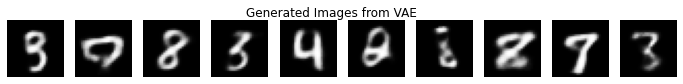

In [17]:
# Number of samples to generate
num_samples = 10

# Sample from the prior distribution (standard normal)
latent_samples = np.random.normal(size=(num_samples, latent_dim))

# Decode the latent samples to generate new images
generated_images = decoder.predict(latent_samples)

# Plot the generated images
plt.figure(figsize=(12, 1.2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated Images from VAE')
plt.show()


# Task 2

In [18]:
'''
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Define the dimensions
original_dim = 785  # Dimension of the input data
latent_dim = 10      # Dimension of the latent space
num_classes = 10    # Number of classes

# Encoder with conditional information
encoder_inputs = layers.Input(shape=(original_dim + num_classes,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder with conditional information
latent_inputs = layers.Input(shape=(latent_dim + num_classes,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='tanh')(x)
decoder_outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Define ELBO loss function
def elbo_vae(x, x_decoded_mean, z_mean, z_log_var):
    reconstruction_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

# Define conditional VAE class
class ConditionalVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        if isinstance(data, tuple):  # Check if data is passed as a tuple
            x, y = data  # Input data and class information
        else:
            x = data  # Input data only
            y = None

        with tf.GradientTape() as tape:
            if y is not None:
                z_mean, z_log_var, z = self.encoder(tf.concat([x, y], axis=-1))
                reconstruction = self.decoder(tf.concat([z, y], axis=-1))
            else:
                z_mean, z_log_var, z = self.encoder(x)
                reconstruction = self.decoder(z)

            total_loss = -elbo_vae(x, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}


    
# One-hot encode the labels
num_classes = 10
y_train_one_hot = tf.one_hot(y_train, num_classes)
y_test_one_hot = tf.one_hot(y_test, num_classes)

# Define the ConditionalVAE model
conditional_vae = ConditionalVAE(encoder, decoder)

# Compile the model
conditional_vae.compile(optimizer='adam')

# Train the model
conditional_vae.fit([x_train, y_train_one_hot], epochs=10, batch_size=128)
'''

'\nfrom tensorflow.keras import layers\nimport tensorflow.keras.backend as K\n\n# Define the dimensions\noriginal_dim = 785  # Dimension of the input data\nlatent_dim = 10      # Dimension of the latent space\nnum_classes = 10    # Number of classes\n\n# Encoder with conditional information\nencoder_inputs = layers.Input(shape=(original_dim + num_classes,))\nx = layers.Dense(256, activation=\'relu\')(encoder_inputs)\nx = layers.Dense(256, activation=\'tanh\')(x)\nz_mean = layers.Dense(latent_dim, name="z_mean")(x)\nz_log_var = layers.Dense(latent_dim, name="z_log_var")(x)\nz = Sampling()([z_mean, z_log_var])\nencoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")\nencoder.summary()\n\n# Decoder with conditional information\nlatent_inputs = layers.Input(shape=(latent_dim + num_classes,))\nx = layers.Dense(256, activation=\'relu\')(latent_inputs)\nx = layers.Dense(256, activation=\'tanh\')(x)\ndecoder_outputs = layers.Dense(original_dim, activation=\'sigmoid\')(x)\

# Task 3

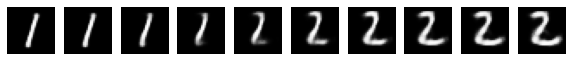

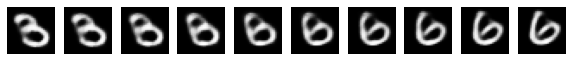

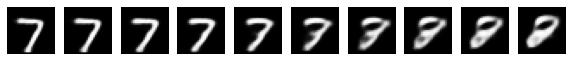

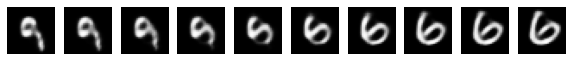

In [19]:
def interpolate_digits(y_start, y_end, n_steps=10):
    # Encode the numbers
    encoded_target = encoder.predict(np.array([x_test[y_test == y_start][0]]))[0]
    encoded_reference = encoder.predict(np.array([x_test[y_test == y_end][0]]))[0]
    # Generate interpolated representations
    interpolated = []
    for i in range(n_steps):
        # alpha = 0,...,1
        alpha = i / (n_steps - 1)
        interpolated_representation = alpha * encoded_reference + (1 - alpha) * encoded_target
        interpolated.append(interpolated_representation[0])

    # Decode interpolated representations
    decoded_interpolated = decoder.predict(np.array(interpolated))

    # Plot the results
    n = len(decoded_interpolated)
    digit_size = int(np.sqrt(original_dim))
    fig = plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(decoded_interpolated[i].reshape(digit_size, digit_size), cmap='Greys_r')
        plt.axis('off')
    plt.show()

# Example usage
interpolate_digits(1, 2)
interpolate_digits(3, 6)
interpolate_digits(7, 8)
interpolate_digits(9, 6)